In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [14]:
import os
import pandas as pd
import numpy as np
import gc
import json
import math
import cv2
import PIL
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.decomposition import PCA

from plotly.subplots import make_subplots


%matplotlib inline 
# output plot for each cell directly

In [5]:
print(os.listdir("../input/siim-isic-melanoma-classification"))

['test.csv', 'train', 'jpeg', 'sample_submission.csv', 'train.csv', 'tfrecords', 'test']


In [6]:
#load train and test data
train = pd.read_csv("../input/siim-isic-melanoma-classification/train.csv")
test = pd.read_csv("../input/siim-isic-melanoma-classification/test.csv")
print("{} images in train set.".format(train.shape[0]))
print("{} images in test set.".format(test.shape[0]))

33126 images in train set.
10982 images in test set.


In [7]:
for col in train.columns:
    print(col)

train.head(5)

image_name
patient_id
sex
age_approx
anatom_site_general_challenge
diagnosis
benign_malignant
target


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [8]:
test.head(5)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


Explore variables and its distribution

In [9]:
print(np.mean(train['target']))

0.01762965646320111


/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


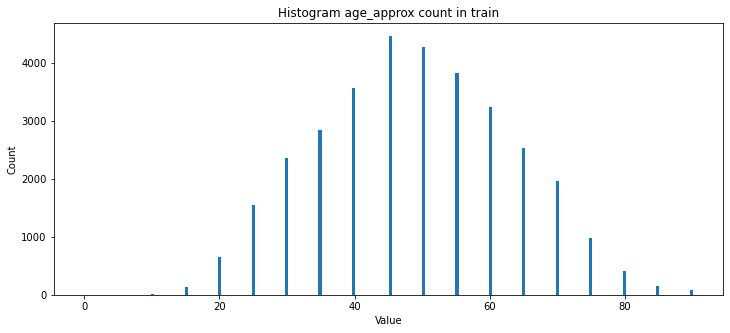

In [10]:
# age distribution
plt.figure(figsize = (12,5))
plt.hist(train['age_approx'].values, bins=200)
plt.title("Histogram age_approx count in train")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()

One patient can have as many as 115 samples and as few as 2 samples

In [11]:
#how many samples per patient
print("{} petients inside the train dataset".format(train["patient_id"].nunique()))
train.patient_id.value_counts()

2056 petients inside the train dataset


IP_7279968    115
IP_4479736    115
IP_4382720    115
IP_4938382    115
IP_0656529    114
             ... 
IP_3994830      3
IP_5851912      3
IP_9006739      3
IP_0517623      3
IP_8335299      2
Name: patient_id, Length: 2056, dtype: int64

In [12]:
print("Gender distribution")
print(train.sex.value_counts(dropna = False))
print("")
print("Body part of sampling")
print(train.anatom_site_general_challenge.value_counts(dropna = False))
print("")
print("Diagnosis distribution")
print(train.diagnosis.value_counts(dropna = False))

Gender distribution
male      17080
female    15981
NaN          65
Name: sex, dtype: int64

Body part of sampling
torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
NaN                  527
palms/soles          375
oral/genital         124
Name: anatom_site_general_challenge, dtype: int64

Diagnosis distribution
unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
atypical melanocytic proliferation        1
cafe-au-lait macule                       1
Name: diagnosis, dtype: int64


**Study distribution of datasets,** taken from the kernel here: https://www.kaggle.com/anshuls235/melanoma-eda-prediction-using-lightgbm

In [16]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

group_age_train = train.groupby('age_approx')['patient_id','image_name'].nunique()
group_age_test = test.groupby('age_approx')['patient_id','image_name'].nunique()
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, horizontal_spacing=0.01,
                    subplot_titles=['Patients and their age',
                                   'Images available wrt age'])
fig.add_trace(go.Bar(y=group_age_train.index,x=group_age_train['patient_id'],orientation='h',name='Train',
                        legendgroup='Train',marker_color='rgb(55, 83, 109)'),1,1)
fig.add_trace(go.Bar(y=group_age_test.index,x=group_age_test['patient_id'],orientation='h',name='Test',
                       legendgroup='Test',marker_color='rgb(26, 118, 255)'),1,1)
fig.add_trace(go.Bar(y=group_age_train.index,x=group_age_train['image_name'],orientation='h',name='Train',
                 legendgroup='Train',marker_color='rgb(55, 83, 109)',showlegend=False),1,2)
fig.add_trace(go.Bar(y=group_age_test.index,x=group_age_test['image_name'],orientation='h',name='Test',
                 legendgroup='Test',marker_color='rgb(26, 118, 255)',showlegend=False),1,2)
fig.update_yaxes(title_text='Age',row=1,col=1)
fig.update_xaxes(title_text='Number of Patients',row=1,col=1)
fig.update_xaxes(title_text='Number of Images',row=1,col=2)
fig.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [19]:
# further explanation for above plot
print(group_age_train)
print("")
print(group_age_train.index)

            patient_id  image_name
age_approx                        
0.0                  1           2
10.0                10          17
15.0                29         132
20.0                55         655
25.0               133        1544
30.0               217        2358
35.0               287        2850
40.0               364        3576
45.0               450        4466
50.0               452        4270
55.0               411        3824
60.0               338        3240
65.0               261        2527
70.0               217        1968
75.0               153         981
80.0                70         419
85.0                29         149
90.0                17          80

Float64Index([ 0.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0,
              60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0],
             dtype='float64', name='age_approx')


In [20]:
group_sex_train = train.groupby('sex')['patient_id','image_name'].nunique()
group_sex_test = test.groupby('sex')['patient_id','image_name'].nunique()
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, horizontal_spacing=0.01,
                    subplot_titles=['Patients and their sex',
                                   'Images available wrt sex'])
fig.add_trace(go.Bar(y=group_sex_train.index,x=group_sex_train['patient_id'],orientation='h',name='Train',
                        legendgroup='Train',marker_color='rgb(55, 83, 109)'),1,1)
fig.add_trace(go.Bar(y=group_sex_test.index,x=group_sex_test['patient_id'],orientation='h',name='Test',
                       legendgroup='Test',marker_color='rgb(26, 118, 255)'),1,1)
fig.add_trace(go.Bar(y=group_sex_train.index,x=group_sex_train['image_name'],orientation='h',name='Train',
                 legendgroup='Train',marker_color='rgb(55, 83, 109)',showlegend=False),1,2)
fig.add_trace(go.Bar(y=group_sex_test.index,x=group_sex_test['image_name'],orientation='h',name='Test',
                 legendgroup='Test',marker_color='rgb(26, 118, 255)',showlegend=False),1,2)
fig.update_yaxes(title_text='Sex',row=1,col=1)
fig.update_xaxes(title_text='Number of Patients',row=1,col=1)
fig.update_xaxes(title_text='Number of Images',row=1,col=2)
fig.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [21]:
group_site_train = train.groupby('anatom_site_general_challenge')['patient_id','image_name'].nunique()
group_site_test = test.groupby('anatom_site_general_challenge')['patient_id','image_name'].nunique()
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, horizontal_spacing=0.01,
                    subplot_titles=['Imaged site vs Patients',
                                   'Imaged site vs Images'])
fig.add_trace(go.Bar(y=group_site_train.index,x=group_site_train['patient_id'],orientation='h',name='Train',
                        legendgroup='Train',marker_color='rgb(55, 83, 109)'),1,1)
fig.add_trace(go.Bar(y=group_site_test.index,x=group_site_test['patient_id'],orientation='h',name='Test',
                       legendgroup='Test',marker_color='rgb(26, 118, 255)'),1,1)
fig.add_trace(go.Bar(y=group_site_train.index,x=group_site_train['image_name'],orientation='h',name='Train',
                 legendgroup='Train',marker_color='rgb(55, 83, 109)',showlegend=False),1,2)
fig.add_trace(go.Bar(y=group_site_test.index,x=group_site_test['image_name'],orientation='h',name='Test',
                 legendgroup='Test',marker_color='rgb(26, 118, 255)',showlegend=False),1,2)
fig.update_yaxes(title_text='Location of imaged site',row=1,col=1)
fig.update_xaxes(title_text='Number of Patients',row=1,col=1)
fig.update_xaxes(title_text='Number of Images',row=1,col=2)
fig.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



**Below plots show the analysis of Imaged sites with respect to Sex, Diagnosis and Tumour type.**

In [22]:
# I have not figured out how does this work as of 0606
fig = make_subplots(rows=1,cols=3,shared_yaxes=True, horizontal_spacing=0.01,
                    subplot_titles=['wrt Sex','wrt Diagnosis','wrt Tumour type'])
group = train.groupby(['anatom_site_general_challenge','sex'],as_index=False)['patient_id'].count().dropna()
for sex in group.sex.unique():
    group_n = group[group['sex']==sex].sort_values('patient_id')
    fig.append_trace(go.Bar(x=group_n['patient_id'],y=group_n['anatom_site_general_challenge'],orientation='h',
                            showlegend=False,name=sex),1,1)
group = train.groupby(['anatom_site_general_challenge','diagnosis'],as_index=False)['patient_id'].count().dropna()
for diag in group.diagnosis.unique():
    group_n = group[group['diagnosis']==diag].sort_values('patient_id')
    fig.append_trace(go.Bar(x=group_n['patient_id'],y=group_n['anatom_site_general_challenge'],orientation='h',
                            showlegend=False,name=diag),1,2)
group = train.groupby(['anatom_site_general_challenge','benign_malignant'],as_index=False)['patient_id'].count().dropna()
for type in group.benign_malignant.unique():
    group_n = group[group['benign_malignant']==type].sort_values('patient_id')
    fig.append_trace(go.Bar(x=group_n['patient_id'],y=group_n['anatom_site_general_challenge'],orientation='h',
                            showlegend=False,name=type),1,3)
fig.update_yaxes(title_text='Imaged site',row=1,col=1)
fig.update_xaxes(title_text='Number of patients', row=1,col=2)
fig.update_layout(title='Imaged site Analysis', barmode='stack',template='seaborn')
fig.show()

**Below plots show the analysis of Sex of patients with respect to their Diagnosis and Tumour type.**

In [24]:
fig = make_subplots(rows=1,cols=2,shared_yaxes=True, horizontal_spacing=0.01,
                    subplot_titles=['Sex wrt Diagnosis','Sex wrt Tumour type'])
group = train.groupby(['sex','diagnosis'],as_index=False)['patient_id'].count().dropna()
for diag in group.diagnosis.unique():
    group_n = group[group['diagnosis']==diag].sort_values('patient_id')
    fig.append_trace(go.Bar(x=group_n['patient_id'],y=group_n['sex'],orientation='h',
                            showlegend=False,name=diag),1,1)
group = train.groupby(['sex','benign_malignant'],as_index=False)['patient_id'].count().dropna()
for type in group.benign_malignant.unique():
    group_n = group[group['benign_malignant']==type].sort_values('patient_id')
    fig.append_trace(go.Bar(x=group_n['patient_id'],y=group_n['sex'],orientation='h',
                            showlegend=False,name=type),1,2)
fig.update_yaxes(title_text='Sex',row=1,col=1)
fig.update_xaxes(title_text='Number of patients',row=1,col=1)
fig.update_xaxes(title_text='Number of patients',row=1,col=2)
fig.update_layout(title='Sex Analysis', barmode='stack',template='seaborn')
fig.show()

# **Explore the images**

In [25]:
images = []
for i, image_id in enumerate(train['image_name'].head(10)):
    im = Image.open(f"../input/siim-isic-melanoma-classification/jpeg/train/{image_id}.jpg")
    im = im.resize((128,)*2, resample = Image.LANCZOS)
    images.append(im)

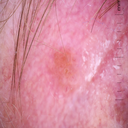

In [26]:
images[0]

# **Explortary DL to train a model using pytorch + gpu**

In [31]:
train_path = '../input/siic-isic-224x224-images/train/'

In [34]:
os.listdir("../input/siic-isic-224x224-images")

FileNotFoundError: [Errno 2] No such file or directory: '../input/siic-isic-224x224-images/'